In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import struct
import random
from tqdm import tqdm

In [2]:
def invert(image):
    image = (255-image)
    return image

def create_data_set(dataset='training', path = './dataset/'):
    
    if dataset is 'training':
        name_images = os.path.join(path, 'train-images.idx3-ubyte')
        name_labels = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is 'testing':
        name_images = os.path.join(path, 't10k-images.idx3-ubyte')
        name_labels = os.path.join(path, 't10k-labels.idx1-ubyte')
    
    with open(name_labels, 'rb') as nlabels:
        magic, num = struct.unpack(">II", nlabels.read(8))
        label = np.fromfile(nlabels, dtype=np.int8)
        
    label = label.tolist()
    with open(name_images, 'rb') as nimages:
        magic, num, rows, cols = struct.unpack(">IIII", nimages.read(16))
        image = np.fromfile(nimages, dtype=np.uint8).reshape(len(label), rows, cols)
    
    data = []
    for i in tqdm(range(len(label))):
        data.append([np.array(label[i]), np.array(image[i])])
        data.append([np.array(label[i]), invert(np.array(image[i]))])
    
    random.shuffle(data)

    return data

In [3]:
train_data = create_data_set()
test_data = create_data_set(dataset='testing')

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 106312.49it/s]


In [4]:
def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    pyplot.show()

In [5]:
LR = 1e-3
model_name = 'mnist_and_inverted-{}-{}.model'.format(LR, 'conv-basic')

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.reset_default_graph()

convnet = input_data(shape=[None, 28, 28,1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 10, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

c:\program files\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
def one_hot_array(labels):
    one_hot = np.zeros((len(labels),10))
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot 

In [7]:
X_train = np.array([i[1] for i in train_data], dtype=np.float32).reshape(-1,28,28,1)

train_y = [i[0] for i in train_data]

Y_train = one_hot_array(train_y)


test = test_data[:-500]
x_test = np.array([i[1] for i in test]).reshape(-1,28,28,1)
test_y = [i[0] for i in test]

y_test = one_hot_array(test_y)


In [8]:
if os.path.exists('{}.meta'.format(model_name)):
    model.load(model_name)
    print('Model loaded')
else:
    model.fit({'input': X_train}, {'targets':Y_train}, n_epoch = 3, validation_set=({'input':x_test}, {'targets':y_test}),
             snapshot_step=500, show_metric=True, run_id= model_name, batch_size = 100)
    model.save(model_name)

Training Step: 3599  | total loss: 0.07657 | time: 111.751s
| Adam | epoch: 003 | loss: 0.07657 - acc: 0.9756 -- iter: 119900/120000
Training Step: 3600  | total loss: 0.08580 | time: 116.180s
| Adam | epoch: 003 | loss: 0.08580 - acc: 0.9740 | val_loss: 0.06177 - val_acc: 0.9807 -- iter: 120000/120000
--


In [9]:
def model_test(data, print_data=False): 
    import matplotlib.pyplot as plt
    plt.clf()
    fig = plt.figure()
    for num, image in enumerate(data):
        img = image[1]
        label = image[0]
        y = fig.add_subplot(3,4, num+1)
        orig = img
        data = img.reshape(28,28,1)
        model_out = model.predict([data])
        if print_data:
            print(model_out)
        str_label = np.argmax(model_out)
        y.imshow(orig, cmap='gray')
        plt.title(str_label)
        fig.tight_layout()
        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)

    plt.show()

<Figure size 432x288 with 0 Axes>

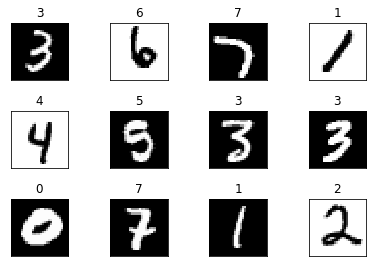

In [10]:
validation_data = test_data[-500:]
random.shuffle(validation_data[:12])
model_test(validation_data[:12])

In [11]:
img_size = 28

def process_sample_data(sample_dir):
    sample_data =[]
    for i in os.listdir(sample_dir):
        path = os.path.join(sample_dir, i)
        img_num = i.split('.')[0]
        img = cv2.resize(cv2.imread(path, 0), (img_size, img_size))
        sample_data.append([img_num, np.array(img)])
    return sample_data

<Figure size 432x288 with 0 Axes>

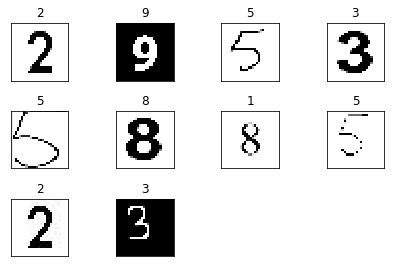

In [12]:
sample = process_sample_data('./sample')
model_test(sample)

# Multiple digits in one image

In [20]:
from IPython.display import Image, display
def find_number(name):
    img = cv2.imread(name,cv2.IMREAD_GRAYSCALE)
    orig_img = cv2.imread(name)
    blur= cv2.GaussianBlur(img, (5,5), 0)
    ret, thresh = cv2.threshold(blur, 90, 255, cv2.THRESH_BINARY_INV)
    temp_img, ctrs, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    output = []
    for rect in rects:
        cv2.rectangle(orig_img, (rect[0]-15, rect[1]-15), (rect[0] + rect[2]+15, rect[1] + rect[3]+15), (0, 255, 0), 1)
        [x, y, w,h ] = rect
        leng = int(rect[3] * 1.6)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        roi = thresh[y: y+h, x:x+w]
        
#        cv2.imshow('roi', roi)
        cv2.waitKey(0)
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)

#         roi = cv2.dilate(roi, (3, 3))
        roi = roi.reshape(28, 28, 1)
        
        out = model.predict([roi])[0]
        number = np.argmax(out)
        output.append(number)
        cv2.putText(orig_img, str(number), (rect[0], rect[1]-15), cv2.FONT_HERSHEY_COMPLEX, 2 , (0, 255, 0), 2, cv2.LINE_AA)
    
    
    cv2.imwrite('./images/'+str(name),orig_img)
    cv2.imshow('Final Image', orig_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print([out for out in output])
    
    display(Image(filename='./images/'+str(name)))


[2, 5, 0, 1, 1, 0, 7, 8]


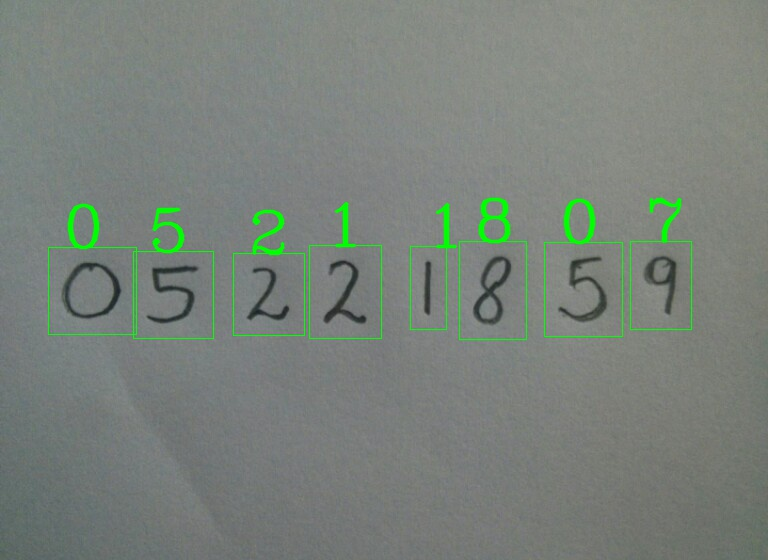

In [21]:
name = 'photo_1.jpg'
find_number(name)